
Imports and constants

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from classifiers.utils.feature_extractors import ColorHistogramTransformer, HuMomentsTransformer, HaralickFeaturesTransformer

from classifiers.utils.load_balanced_data import load_balanced_data_pipeline

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold

# Load and preprocess data

In [4]:
metadata_path = "HAM10000_metadata.csv"
image_dir = "HAM10000_images_part_1"

augmented_images, augmented_labels = load_balanced_data_pipeline(metadata_path, image_dir)

Loading balanced data...
Metadata loaded.
Generating image ID list...
Image ID list generated.
Loading images for augmentation...
Augmenting images...
Images augmented.
Data loading complete.


# Train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Feature extraction and KNN pipeline

In [9]:
feature_union = FeatureUnion([
    ('color_histogram', ColorHistogramTransformer()),
    ('hu_moments', HuMomentsTransformer()),
    ('haralick_features', HaralickFeaturesTransformer())
])

scaler = StandardScaler()

knn_pipeline = Pipeline([
    ('features', feature_union),
    ('scaler', scaler),
    ('classifier', KNN())
])

knn_param_grid = {
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__weights": ['uniform', 'distance'],
}

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, verbose=2, n_jobs=-1)
knn_grid_search.fit(X_train, y_train_1d)

# Predict the labels for the test using KNN pipeline
y_pred = knn_grid_search.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


# Classification report

In [11]:
# Evaluate the KNN classifier
print("KNN Classification Report:")
print(classification_report(y_test_1d, y_pred))
print("Accuracy:", accuracy_score(y_test_1d, y_pred))
print("Best parameters:", knn_grid_search.best_params_)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63        32
           1       0.74      0.62      0.68        40
           2       0.54      0.63      0.58        35
           3       0.64      0.64      0.64        42
           4       0.78      0.65      0.71        43
           5       0.86      0.90      0.88        42
           6       0.86      0.78      0.82        46

    accuracy                           0.71       280
   macro avg       0.71      0.71      0.71       280
weighted avg       0.72      0.71      0.71       280

Accuracy: 0.7107142857142857
Best parameters: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}


# Confusion matrix

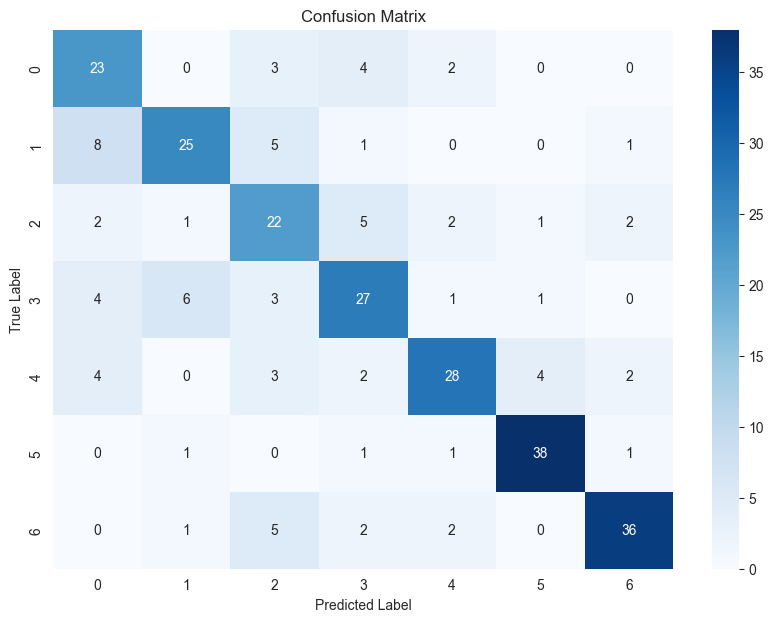

In [12]:
# Compute the confusion matrix
cm = confusion_matrix(y_test_1d, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_1d), yticklabels=np.unique(y_test_1d))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC curve and AUC

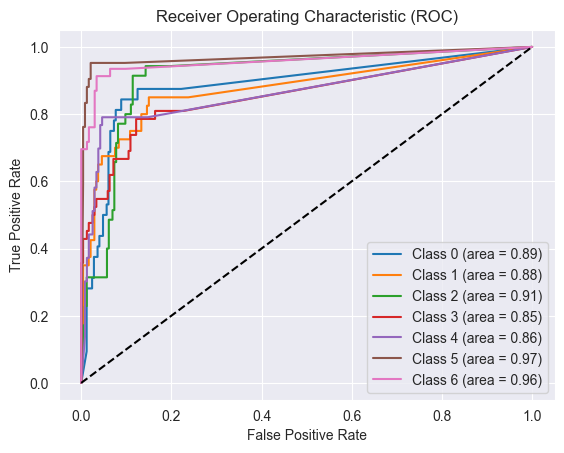

In [13]:
y_score = knn_grid_search.predict_proba(X_test)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_score[:, i])
    
# Plot the ROC curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Learning curves

In [ ]:
# Use StratifiedKFold to maintain the proportion of each class in each fold
cv = StratifiedKFold(n_splits=5)

# Calculate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    knn_grid_search, X_train, y_train_1d, cv=cv, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

/Library/Python/3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

# Precision-Recall curves

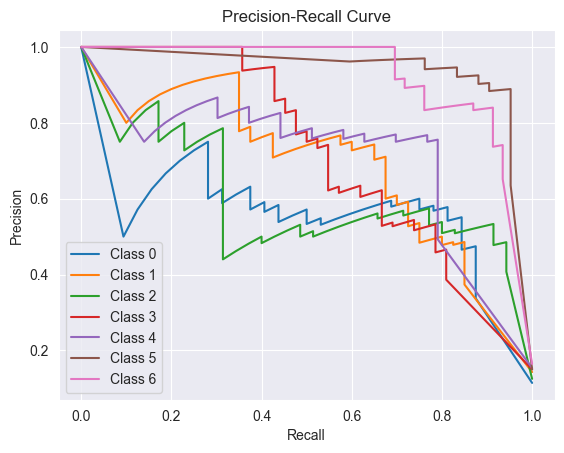

In [15]:
# Compute precision-recall curve for each class
precision = {}
recall = {}
for i in range(y_train.shape[1]):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

# Plot Precision-Recall curve for each class
plt.figure()
for i in range(y_train.shape[1]):
    plt.plot(recall[i], precision[i], label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Save the model

In [16]:
import joblib

joblib_file = "knn_classifier.pkl"
joblib.dump(knn_grid_search.best_estimator_, joblib_file)

['knn_classifier.pkl']